# Task 2: Deep Learning Regression Models and K-Fold Validation

**Note**: I have run the code on a local machine GPU due to limited resources provided by the Google Colab platform. Therefore, you might get different results than mine even though the reproducibility measures applied below. That's just how GPUs work...

To begin with, we provide a walkthrough on how to replicate the task on Google Colab. First, we need to extract the soybean dataset from the ZIP file (download from MyAberdeen). Therefore, we first mount our drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Then, we upload the dataset ZIP file to our google drive and execute:

    !unzip your_drive_path_to_soybean_images.zip -d './data/' 

where *your_drive_path_to_soybean_images.zip* should be replaced by the actual path of the dataset ZIP file on your drive.

Alternatively, we can place the dataset zip file in the current directory and execute (tested in colab):

    !unzip 'soybean_images.zip' -d './data/' 

Below is the location of the dataset ZIP file on my Google Drive. This will differ in your case, so please adjust as needed.



In [1]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Assessment_1/data/soybean_images.zip' -d './data/'


### Setting a Fixed Seed Value for the Random Number Generator and Importing Libraries

Randomness is in the nature of neural networks which employ it to ensure a better performance on a specific task. However, we need to seed the random number generator to get reproducible results when training and comparing models. 

*Note that randomness might still occur such as the random initialisation of model weights when constructing a model. Thus, the output results might differ each time the script is run (generally on GPU). We put great deal of effort into making the script results as repeatable as possible.*

- First, we install the new Tensorflow determinism package allowing reproducibility on GPUs.


- Then, we seed the random number generators and import the required packages for model development and visualisation (i.e tensorflow, keras, matplotlib).

In [ ]:
# Install the determinism package of Tensorflow
# If the program throws attribute error the simply
# uninstall the Keras package (since tensorflow already
# provides it)
!pip install tensorflow-determinism

In [1]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# Import the Keras backend used for freeing the global state
# to avoid clutter
from tensorflow.keras import backend as K

# Import the necessary packages used for training and evaluation 
# of our model later on
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
%matplotlib inline

## Subtask a. Data Import / Pre-Processing

### Importing the Data

We load the NPZ-formatted data from our data folder using the `numpy.load()` function. We divide each loaded sample to a histogram image and its corresponding average crop yield value. Then we add these in the `image` and `labels` lists correspondingly. Finally, we convert the Python lists into NumPy arrays since they provide better functionality and are generally more efficient.

In [2]:
# The 'soybean_images' dataset path on our working directory
data_dir = './data/soybean_images/'

# Lists to store the histogram images 
# and their corresponding labels
images = []
labels = []

# Load the data
for f in os.listdir(data_dir):
    sample = np.load(data_dir + str(f))
    images.append(sample['image'])
    labels.append(sample['y'])

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

### Data Pre-Processing

Let's first see some description of our data.

In [3]:
# Print some data info
print('\033[1mHistogram image data\033[0m: \n')
print(f'    Shape: {images.shape}')
print(f'    Min pixel value: {np.min(images)}')
print(f'    Max pixel value: {np.max(images)}\n')

print('\033[1mLabels data\033[0m: \n')
print(f'    Shape: {labels.shape}')
print(f'    Min value: {np.min(labels)}')
print(f'    Max value: {np.max(labels)}\n')

Histogram image data: 

    Shape: (22986, 9, 32, 32)
    Min pixel value: 0.0
    Max pixel value: 1.0

Labels data: 

    Shape: (22986,)
    Min value: 0.7
    Max value: 82.3



Normally, we would like to normalise/standardise our training data. With images, this is carried out by scaling the pixel values to a certain range. Pixel scaling provides:

- **Image impartiality**: scaling data images to a range (i.e. `[0,1]` or `[-1,1]`) enables all photos to contribute equally to the overall loss, as opposed to when other images have high and low pixel ranges, resulting in strong and weak loss, respectively. 


- **Uniform learning rate**: re-scaling helps offer a standard learning rate for all images since high pixel values require a low learning rate whereas low pixel values demand a high learning rate. 


Above, we can see that our image pixels are already in the `[0,1]` range, therefore pixel scaling is not necessary. Also, we do not want to alter out target values (labels) since it is an unnecessary step that can potentially obscure the interpretation of our results. This is, we would essentially be predicting a distribution that does not represent our real-world target (at least without some reverse non-linear transforms later on).

## Splitting to Train-Test Data

The optimal split depends on the amount of available data and the bias/variance characteristics. 

- Less training data equals greater parameter estimate variance


- Less testing data causes a greater variance in performance statistics.

As we saw previously our data consists of roughly 23000 data instances (images) which is a decent amount. When there is a substantial amount of data available it does not really matter if we pick 80:20 or 90:10 split. Since we want to cover the variance of our data and we expect a computationally intensive training procedure, we pick the 80:20 split ratio. This split ratio is probably the most commonly occuring one and is usually a safe bet when one is unsure about what ratio to pick. 

In [304]:
# Shuffle and split the data into a train set (80%) and 
# a separate holdout test set (20%)
X_train, X_test, y_train, y_test \
    = train_test_split(images, labels, test_size=0.2, \
                       shuffle=True, random_state=1337)

Below, we visualise a small part of the data images to get a better understanding.

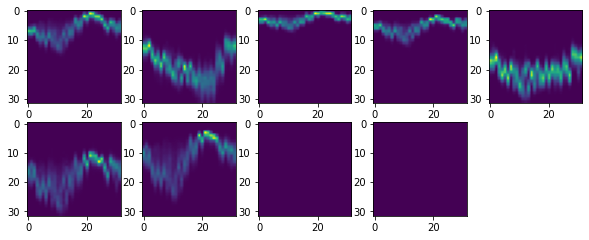

In [6]:
# Plot some of the soybean dataset images
# to visualise our input
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[10000][i].T)
plt.show()

### Input Data Reshaping 

Below we define the input shape or the data (image) format so that it is handled properly by our model. 

- Since the histogram images are 32 x 32 pixels and infrared 9 channels (as seen previously), we define our input shape as the `(32, 32, 9)` 3-tuple. Here, each value represents the image width, the height and number of channels respectively. 


- Then, we also reshape our input data (the feature vectors) using the already defined input shape. This is because, our neural network models demand this specific input shape for our images to be handled correctly.


- Also, convert the image pixel data type to `float32` to save memory space and boost runtime performance.

In [7]:
# Define the input shape (image height, image width, channels)
input_shape = 32, 32, 9 

# Reshape the train and test features data
X_train_rs = X_train.reshape(X_train.shape[0], *input_shape)
X_test_rs = X_test.reshape(X_test.shape[0], *input_shape)

# Parse numbers as floats
X_train_32 = X_train_rs.astype('float32')
X_test_32 = X_test_rs.astype('float32')

We show the new data shapes and type.

In [8]:
# Print the new data shapes and type
print(X_train_rs.shape, X_train_32.dtype)
print(X_test_rs.shape)
print(input_shape)

(18388, 32, 32, 9) float32
(4598, 32, 32, 9)
(32, 32, 9)


### Defining a Reset Seed Function (for reproducibility)

In [10]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    # Release the global state to avoid clutter
    # when creating models (in loops etc.)
    K.clear_session()
    
    # Reset the Tensorflow graph
    tf.compat.v1.reset_default_graph()
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

### Developing our Baseline Models

In this section we go over our `CNN` and `MLP` baseline models. These will serve as the foundational models for further tuning and improvement. By adopting them, we set a minimum reference model performances for later comparison.


While developing the neural networks, we can draw inspiration from classic networks such as LeNet, AlexNet, and VGG. We can follow a certain structure when putting the network layers together. For instance, alternating convolutional and pooling layers (`Conv2D-MaxPool2D-Conv2D-...`) and/or filter sizes (`32–32-64–64-...`) etc.

### Importing Model Dependencies

Before training commences we first need to import the dependencies that we require later on:

In [9]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization

#### The CNN Architecture

The basic principle followed in building a convolutional neural network is to ‘keep the feature space wide and shallow in the initial stages of the network, and the make it narrower and deeper towards the end.’

The intuition behind our models are as follows:

- `CNN` &ndash; we define a simplified VGG-style architecture which mimics the one proposed in <a href="https://arxiv.org/pdf/1409.1556.pdf">this paper</a>. Using the Keras `Sequential` API, we construct the `CNN` as a stack of 2 `Conv2D` 32 and 64-filtered layers with small 3 x 3 kernels. Each convolutional layer is followed by a `BatchNormalization` layer (detailed later) and a `MaxPool2D` layer with a 2 x 2 pool size. The goal of the max pooling layer is to down-sample the input data (image, output matrix etc.) by taking the max value of the sub-regions in the data, thus, reducing its dimensionality. This significantly decreases the memory demands of the model while preserving its performance almost completely. To reduce overfitting, we also introduce `Dropout` layers into our `Sequential CNN` model after each of the `MaxPool2D` layers. We initialise the dropout rate to 0.25 which means that 25% of the layer inputs will be dropped out (discarded/converted to 0). Additionally, the `CNN's` initial layers (`Conv2D` and `MaxPool2D`) have multidimensional tensors as outputs. Consequently, if we want to use a `Dense` (fully-connected) layer after the initial part we would need to 'unstack' the multidimensional outputs into long 1D tensors. To accomplish this, we place a Keras `Flatten` layer right before the first `Dense` layer of our `CNN` just for that purpose. Also, there is another `BatchNormalization` layer in-between the `Dense` layers.

<center>
<br>
<figure>
<img src="https://drive.google.com/uc?id=1Gez1vuZp2UiWpfJFwSyDmO8Oxm2obEMK" width="250">
<br>
<figcaption style="text-align:center"><b>Fig. 1.</b> Baseline CNN architecture.</figcaption>
</figure>
<br>
</center>

Considering `CNNs`, it is recommended to begin with smaller filter sizes for better local information capturing. That is, to enable the model to detect low-level features used in forming complex shapes later on. As we go deeper we gradually increase the filter size which reduces the resulting feature space to reflect higher-level information. Moreover, deepening and narrowing the feature space allows the input to be fed into a `Dense` layer. 


- Activation function &ndash; We adopt the `ReLU` activation function to achieve nonlinearity. It is recommended as the default for both `MLP` and `CNNs`. It is preferred over `tanh` and `sigmoid` activation functions due to its trivial implementation (requires only a `max()` function), representational sparsity (outputs a true zero value), linear function characteristics (easier to optimise) and enables proper deep neural network training.


- Batch normalisation &ndash; intermediate layers are capable of amending the already normalised input before it gets to the deeper layers of the neural network. This might cause an internal co-variate shift that can influence the model learning. A solution to this problem is adding the `BatchNormalization` layer which standardises (centers the mean and scales the variance) the input passed to the inner layers. This layer is generally placed after the activation function output but before the `Dropout` layer (if any). The <a href="https://arxiv.org/abs/1502.03167">original paper</a> that introduces the technique suggests otherwise. Nevertheless, there are reported <a href="https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md">practical experiments</a> suggesting that the application of the `BatchNormalization` layer after the activation function yields better results. This seems rather reasonable since feeding the batch-normalised output to an activation layer would lead to its alteration and would nullify the conducted normalisation. Hence, we put the `BatchNormalization` layer after the activation function in our `CNN` and `MLP` networks.

In [12]:
def cnn_model(filters_1=32, filters_2=64, units=256):
    """Define and return the CNN model architecture
    """
    # Ensure reproducibility of the results
    reset_random_seeds()

    # Build the model
    model = Sequential()
    model.add(Conv2D(filters_1, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters_2, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1))
    
    return model

#### The MLP Architecture

The `MLP` architectures is not as complex as the `CNN` one; rather, it’s simply a stack of so-called densely-connected ones. That means that an arbitrary neuron is connected to all neurons in the subsequent layer. We draw inspiration from <a href="https://www.sciencedirect.com/science/article/pii/S2352484720314505">this paper</a>.


As discussed before, the Keras Sequential API is used for creating the model. To construct our baseline `MLP` model we use 1 input `Flatten` layer and 3 hidden `Dense` layers. Also, the first 2 hidden layers are followed by a `Dropout` layer with `rate=0.25` to decrease overfitting:


- `Flatten()` &ndash; we pass the input tensor through a flattening layer first. The `Flatten` Keras layer 'flattens' or reshapes the input data into a 1D array. This means that all of the dimensions are removed except for one (reshaped/squished into 1).


- `Dense(64)` &ndash; we define the first fully-connected layer with 64 outputs


- `Dropout(0.25)` &ndash; a dropout layer with 25% drop rate


- `Dense(32)` &ndash; second fully-connected layer with 32 outputs


- `Dropout(0.25)` &ndash; a dropout layer with 25% drop rate


- `Dense(1)` &ndash; a single output for the final layer since we are dealing with a crop yield prediction regression problem.

<center>
<br>
<figure>
<img src="https://drive.google.com/uc?id=1QIXvmPfqpYhhGsLnGRkpODJSMp5x7KuD" width="175">
<br>
<figcaption style="text-align:center"><b>Fig. 2.</b> Baseline MLP architecture.</figcaption>
</figure>
<br>
</center>

The final `Dense` layer has 1 output neuron and activates linearly (no function specified). Using the linear function allows us to generate a real-valued or numeric prediction, which is exactly what we need. That is, we do not want to change in any way our prediction output which non-linear activation functions in the last layer might cause.

Starting with a wider fully-connected layer in our architecture, we consider greater number of features before converging to the actual prediction.

We use `ReLU` based activation because it is one of the standard activation functions used nowadays (as detailed above).

Next, we define the MLP in code:

In [13]:
def mlp_model(units_1=64, units_2=32):
    """
    Define and return the MLP model architecture
    """
    # Ensure reproducibility of the results
    reset_random_seeds()

    # Build and return the MLP model
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(units_1, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(units_2, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    
    return model

### Defining the Baseline Model Configuration

- **Batch size** &ndash; The batch size is a hyperparameter used for spicifying the amount of samples that will be sent across the network. As a kickoff, we use a batch size of 32 samples which is stated to be a good default value in the <a href="https://arxiv.org/abs/1206.5533">following paper</a>. In general, smaller batch sizes are mainly used because they offer regularisation and improved generalisation.


- **Epochs** &ndash; this is the number of passes of the whole training dataset the algorithm is expected to complete. We use 10 epochs to quickly evaluate our baseline models. We will adjust this hyperparameter later on when we conduct the model hyperparameter optimisation procedure.


- **Validation split** &ndash; we adopt 25% of the training data, or 20% of the whole dataset, for validation training of our baseline models.


- **Optimiser** &ndash; we pick the `Adam` algorithm since it is a popular deep learning method that quickly produces good results. This optimiser combines the advantages of the AdaGrad and RMSProp algorithms into a technique that can tackle sparse gradients on noisy tasks. We use the default `learning_rate=0.001` value of the `Adam` algorithm for our baseline model evaluations which is to be tuned at a later point.


- **Loss function** &ndash; we use the Mean Squared Error (`MSE`) loss function which is the default for regression problems. Furthermore, we choose the `RMSE` metric to report the performance of our models. 


Finally, we wish to see as much output as possible, thus configure the training process to be verbose.

In [14]:
# Baseline model hyperparameter configuration
batch_size = 32
no_epochs = 10
validation_split = 0.25
optimiser = 'adam'
loss_function = 'mse'
metrics = [tf.keras.metrics.RootMeanSquaredError()]
verbosity = 1

### Training and Evaluating the Baseline Models

Here, we finally compile the models and start the training process. We train our models on the whole training data since we consider them as finalised models which will be measured against the hypertuned (adjusted hyperparameters) models.

With large data sets we get to split it into 3 parts &ndash; training, validation and test sets. We have around 23000 image instances, so it safe to say that we have good amount of data. Given that we already split the data into training and test sets, we achieve the validation split by adopting the `validation_split` parameter of the Keras `fit()` method.

- **Note**: We use `validation_split=0.25` which reserves 25% of the training data ($80\% \times 25\% = 20\%$ of the whole dataset) for loss validation purposes. This is used to check if the model is overfitting and detecting a stopping epochAlso, we have already shuffled the data when splitting into train and holdout test sets so the validation split data would also comprise shuffled data.


#### The CNN Model

In this part we proceed as follows:


1. Build the `CNN` baseline model.


2. Compile the `CNN` model.


3. Fit the baseline model to the training data.


4. Evaluate the baseline `CNN` model on the holdout test set.


5. Plot the training loss curve (validation included).


We also provide brief summaries and analysis along with the results.

In [15]:
# Get the CNN model architecture
base_cnn = cnn_model()

Random number generator seed reset!


In [16]:
# Compile the CNN model
base_cnn.compile(optimizer=optimiser, loss=loss_function, metrics=metrics)

# Early stopping method (we will not need it here really...)
es_callback = tf.keras.callbacks.\
    EarlyStopping(monitor='val_root_mean_squared_error', patience=3)

# Train the baseline CNN model on the whole training set and 
# store the training history for later visualisation
cnn_hist = base_cnn.fit(X_train_32, y_train, epochs=no_epochs, 
                        validation_split=validation_split,
                        batch_size=batch_size, verbose=verbosity,
                        callbacks=[es_callback])

Epoch 1/10
431/431 [==============================] - 12s 12ms/step - loss: 692.9207 - root_mean_squared_error: 26.3234 - val_loss: 939.8645 - val_root_mean_squared_error: 30.6572
Epoch 2/10
431/431 [==============================] - 5s 11ms/step - loss: 47.5565 - root_mean_squared_error: 6.8961 - val_loss: 48.9652 - val_root_mean_squared_error: 6.9975
Epoch 3/10
431/431 [==============================] - 5s 11ms/step - loss: 43.7982 - root_mean_squared_error: 6.6180 - val_loss: 56.0442 - val_root_mean_squared_error: 7.4863
Epoch 4/10
431/431 [==============================] - 5s 12ms/step - loss: 41.0135 - root_mean_squared_error: 6.4042 - val_loss: 42.2985 - val_root_mean_squared_error: 6.5037
Epoch 5/10
431/431 [==============================] - 5s 11ms/step - loss: 38.4024 - root_mean_squared_error: 6.1970 - val_loss: 37.7427 - val_root_mean_squared_error: 6.1435
Epoch 6/10
431/431 [==============================] - 5s 11ms/step - loss: 36.6553 - root_mean_squared_error: 6.0544 - v

As shown above, we obtain a training `RMSE` $\approx 5.6403$ (on local GPU). It is also obvious that the loss `MSE` and the training `RMSE` are decreasing throughout the epochs, therefore, there is no sign of overfitting.

Next, we evaluate our `CNN` model on the holdout test set.

In [179]:
# Evaluate the CNN and store the output in a Pandas data frame
base_cnn_res = base_cnn.evaluate(X_test_32, y_test, verbose=1)
cnn_base_df = pd.DataFrame(base_cnn_res, index=['MSE', 'RMSE'], columns=['MLP Test Loss'])
cnn_base_df

144/144 [==============================] - 1s 6ms/step - loss: 30.6740 - root_mean_squared_error: 5.5384


,MLP Test Loss
MSE,30.674002
RMSE,5.538412


In just 10 epochs, we achieve an evaluation `RMSE` $\approx 5.5384$ (on GPU) which is a satisfactory result regarding the outputs mentioned in <a href="https://arxiv.org/pdf/2104.07468.pdf">your work :)</a>. From this we can also infer that `CNN` models are a useful deep learning tool for regression problems.

Now, let us visualise the `CNN` training process by plotting the per epoch training and validation losses. We display the loss curve of our model which is one of the most commonly used graphs for debugging a neural network. 

In [158]:
# Import the matplotlib module used for visualisation
import matplotlib.pyplot as plt

def plot_history(history, name, clrs=['blue', 'orange']):
    """Plot diagnostic learning curves from the model training history
    """
    plt.figure(figsize=(7,6))
    plt.style.use('seaborn-whitegrid')
    plt.plot(history.history['root_mean_squared_error'], color=clrs[0], label='train')
    plt.plot(history.history['val_root_mean_squared_error'], color=clrs[1], label='test')
    plt.title(f'{name} Model Loss', fontsize=16)
    plt.ylabel('Loss (RMSE)', fontsize=14)
    plt.xlabel('\nEpoch', fontsize=14)
    plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 14})
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    plt.close()

Below, we output the training and validation loss curves of our model.

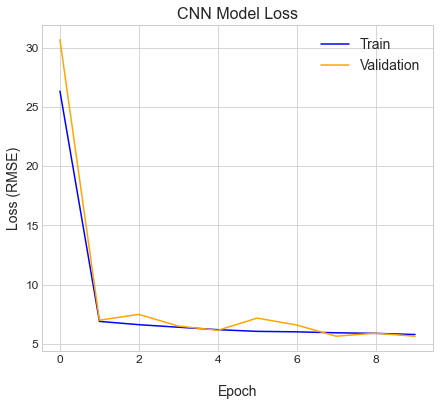

In [159]:
# Plot the baseline CNN model training 
# and validation loss curves
plot_history(cnn_hist, 'CNN')

The training loss curve tells us that `Adam` optimiser's default learning rate is about right. The effect of the learning rate is better illustrated in the following figure:

<img src="https://cs231n.github.io/assets/nn3/learningrates.jpeg"/>
<center><b>Fig 3.</b> The effect of model learning rate on loss (<a href="https://cs231n.github.io/assets/nn3/learningrates.jpeg">source link</a>)
.</center>

#### The MLP Model

The steps we take are:


1. Build the `MLP` baseline model.


2. Compile the `MLP` model.


3. Fit the baseline model to the training data.


4. Evaluate the baseline `MLP` model on the holdout test set.


5. Plot the training loss curve (validation included).


We also provide comments and analysis along with the results.

In [20]:
# Build the baseline MLP model architecture
base_mlp = mlp_model()

Random number generator seed reset!


In [21]:
# Compile the CNN model
base_mlp.compile(optimizer=optimiser, loss=loss_function, metrics=metrics)

# Fit the baseline CNN model to the training data and 
# store the training history for later visualisation
mlp_hist = base_mlp.fit(X_train_32, y_train, epochs=no_epochs,
                        validation_split=validation_split,
                        batch_size=batch_size, verbose=verbosity)

Epoch 1/10
431/431 [==============================] - 3s 6ms/step - loss: 184.3731 - root_mean_squared_error: 12.0806 - val_loss: 64.0614 - val_root_mean_squared_error: 8.0038
Epoch 2/10
431/431 [==============================] - 3s 7ms/step - loss: 98.0049 - root_mean_squared_error: 9.8997 - val_loss: 50.4832 - val_root_mean_squared_error: 7.1052
Epoch 3/10
431/431 [==============================] - 3s 7ms/step - loss: 92.1099 - root_mean_squared_error: 9.5974 - val_loss: 47.5385 - val_root_mean_squared_error: 6.8948
Epoch 4/10
431/431 [==============================] - 3s 6ms/step - loss: 84.5732 - root_mean_squared_error: 9.1964 - val_loss: 45.4565 - val_root_mean_squared_error: 6.7421
Epoch 5/10
431/431 [==============================] - 3s 7ms/step - loss: 81.4841 - root_mean_squared_error: 9.0269 - val_loss: 43.0469 - val_root_mean_squared_error: 6.5610
Epoch 6/10
431/431 [==============================] - 3s 7ms/step - loss: 77.3313 - root_mean_squared_error: 8.7938 - val_loss: 

- The above results demonstrate a validation `RMSE` of $\approx 5.8323$ (on GPU) regarding the `MLP` baseline model. 


- Additionally, the `MLP` architecture training performance `RMSE` shows an increase of $\approx 3.4\%$ as opposed to the `CNN` model. 


- Again, there is no sign of overfitting or underfitting since the error rate is gradually dropping throughout the epochs.

In [178]:
# Evaluate the baseline MLP model and store the results in a Pandas data frame
base_mlp_res = base_mlp.evaluate(X_test_32, y_test, verbose=1)
mlp_base_df = pd.DataFrame(base_mlp_res, index=['MSE', 'RMSE'], columns=['MLP Test Loss'])
mlp_base_df

144/144 [==============================] - 1s 5ms/step - loss: 33.2146 - root_mean_squared_error: 5.7632


,MLP Test Loss
MSE,33.214592
RMSE,5.763210


- The baseline `MLP` algorithm demonstrates an increase of  $\approx 4.06\%$ in `RMSE` loss as opposed to the `CNN` model regarding generalisation on unseen data (holdout test set). It gives an evaluation `RMSE` $\approx 5.7632$ (on local GPU).

So far, the `MLP` baseline model falls behind the `CNN` in terms of training and test `RMSE` errors. The `CNN` is generally expected to perform better, since it is a more sophisticated architecture. It is also better suited for tasks involving spatial relation and complex images. However, let us assume that such performance outcome could be caused by the hyperparameter settings such as `batch_size`, filter number in the `Conv2D` layers, learning rate, number of epochs etc. Therefore, we would get a better performance estimate after hyperparameter optimisation which we will go through in the following parts.

We plot the `MLP` training loss curve to analyse its performance better.

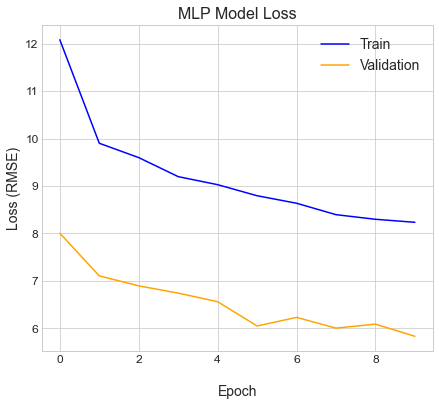

In [170]:
# Plot the MLP training and validation RMSE loss curves
plot_history(mlp_hist, 'MLP')

The `MLP` loss plot tells us that 10 epochs are not enough for the model to fully converge. Considering Figure 3 and the previous plot, we can conclude that the learning rate of the baseline `MLP` model is lower than it should be (or at least not the right one). Also, we have to make sure the model starts overfitting and detect when this occurs in order to acquire the best `RMSE` result. We will try to fix these in the following section where we perform hyperparameter optimisation for both models.

### `MLP` vs `CNN`

In general, both architectures show good performance on this regression task of crop yield prediction. Below, we try to give detailed notes and analyse the advantages and disadvantages of both architectures:

- `MLP` &ndash; it is effective in dealing with more basic datasets. Nevertheless, `MLP`s are no longer considered adequate for contemporary sophisticated computer vision tasks, i.e., image classification. They are outperformed by the state-of-the-art 'fancy' architectures like the `CNN`, `LSTM` etc. The `MLP` can also be regarded as the descendant of the `CNN`. A notable disadvantage of the `MLP` is that the number of total neurons (width x height x depth) can increase drastically since it utilises fully-connected layers. This makes it impractical due to the repetition in such complex dimensions. Moreover, `MLP`s are not suitable for spatial data since input that is being fed should be in the form of a flattened vector which eleminates the spatiality. 


- `CNN` &ndash; winner of multiple ImageNet challenges, the `CNN`  architecture is the current preferred choice for computer vision tasks. Furthermore, `CNN`s are easier to train, more efficient and resource saving algorithms than `MLP`s. They can be built with more layers (deeper) since they employ sparsely connected layers as opposed to `MLP`s. The `CNN` architecture accepts both matrices and vectors as inputs. It is suitable for various problem domains such as pattern recognition, document analysis and many more.

The results acquired might be influenced by several factors, for instance:


- hyperparameter values (learning rate etc.)


- randomly initialised model weights (even though we tried to mitigate, results obtained might differ when using GPU)


- dataset train test split etc.


Now let us tune some models and see if anything changes, shall we?

### Hyperparameter Optimisation and Model Selection


For hyperparameter optimisation and model selection procedures we employ the `keras-tuner` library by Keras.

- "The Keras Tuner is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called hyperparameter tuning or hypertuning." &mdash; <a href="https://www.tensorflow.org/tutorials/keras/keras_tuner">TensorFlow</a>

Firstly, we install and import the Keras Tuner.

In [24]:
# Install and import the keras_tuner package
!pip -q install keras-tuner
import keras_tuner as kt

#### Defining our Models

Here, we define our models for hypertuning or *hypermodels*. To do so, we use the model builder function of the Keras Tuner. It returns a compiled version of the model defined and links the specified hyperparameter values to it for the hypertuning process later. 


In [25]:
# Add the MAE metric to the metrics list
metrics.append(tf.keras.metrics.MeanAbsoluteError())


##### CNN Hypermodel Builder

We focus on tuning the number of filters in the `Conv2D` and number of units in the `Dense` layers together with the `Adam` learning rate hyperparameter.


- 1st `Conv2D` layer filters &ndash; these are to be tuned in the `[32, 64]` range with `step=32`.


- 2nd `Conv2D` layer filters &ndash; these are to be tuned in the `[64, 128]` range with `step=64`.


- `Dense` layer units &ndash; these are to be tuned in the `[128, 256]` range with `step=128`.


- `Adam` learning rate &ndash; to be adjusted in the `[0.01, 0.001, 0.0001]` range. We use this range since we are not completely sure if the default learning rate is high or too low. Therefore, we explore both directions for the tuning process.

The learning rate defines how quickly a network updates its parameters hence an important hyperparameter to tune. We choose to adjust and test the number of layer filters/units to see if there is a better configuration present. A large number of units within a layer with regularization techniques can increase accuracy. Smaller number of units may cause underfitting. Therefore, this hyperparameter is crucial for the performance of a model, thus, is to be considered in the hypertuning.

- **Note**: We decide to keep the default structure of our models (no additional layer insertion) and try to improve their performance by experimenting with the layer parameters. For instance, we explore different filter and unit numbers for the `Conv2D` and `Dense` layer respectively, various learning rates for the `Adam` optimiser and also different `batch_sizes` when training. 

In [26]:
def cnn_builder(hp):
    """Build and return the CNN hypermodel
    """
    # Choose the number of filter for the Conv2D and 
    # number of units for the Dense layers to tune
    filters_1 = hp.Int('conv_filters_1', min_value=32, max_value=64, step=32)
    filters_2 = hp.Int('conv_filters_2', min_value=64, max_value=128, step=64)
    units = hp.Int('dense_units', min_value=128, max_value=256, step=128)
    
    # Define the CNN
    cnn_hyper = cnn_model(filters_1, filters_2, units)

    # Specify the tuning range for the learning rate of the optimiser.
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the CNN model with the current learning rate choice
    cnn_hyper.compile(optimizer=optimizers.Adam(learning_rate=lr),\
                  loss=loss_function,\
                  metrics=metrics)

    return cnn_hyper

##### MLP Hypermodel Builder

Here, we tune the number of units in the `Dense` layers together with the `Adam` learning rate hyperparameter:

- 1st `Dense` layer units &ndash; these are to be tuned in the `[64, 128]` range with `step=64`.


- 2nd `Dense` layer units &ndash; these are to be tuned in the `[32, 96]` range with `step=32`.


- `Adam` learning rate &ndash; to be adjusted in the `[0.01, 0.001, 0.0001]` range.

In [27]:
def mlp_builder(hp):
    """Build and return the MLP hypermodel
    """
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    units_1 = hp.Int('dense_units_1', min_value=64, max_value=128, step=32)
    units_2 = hp.Int('dense_units_2', min_value=32, max_value=96, step=32)
    
    mlp_hyper = mlp_model(units_1, units_2)

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile the MLP model
    mlp_hyper.compile(optimizer=optimizers.Adam(learning_rate=lr),
                      loss=loss_function, metrics=metrics)

    return mlp_hyper

##### Introducing the Hyperband Tuner and Setting Additional Hyperparameters

The model builder function does not support batch size and epoch hyperparameter value definition. Hence, we need to allow this manually by subclassing the Keras `Tuner` class and overriding the `run_trial()` method. 

In our case, we pick the `Hyperband` tuner class which is a variation of the <a href="https://jmlr.org/papers/volume18/16-558/16-558.pdf">HyperBand algorithm</a>. It speeds up the hyperparameter optimisation procedure through adaptive resource allocation and aggressive early-stopping. `Hyperband` adopts the successive halving technique where, initially, all model candidates are evaluated for only a couple of epochs. Then, only the best half of the candidates 'survive' for the next couple of epochs where the amount of resources (samples) is doubled. This procedure is continued until only two candidates remain in the final iteration. The best candidate is the one who has the highest final evaluation score. 


**Note that the `Hyperband` class has its own logic for setting the epochs, therefore it is not necessary to specify  the range of values for the epochs**

In [28]:
class MyHyperband(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        """Hyperparameters can be added anywhere inside `run_trial`.
        
        When the first trial is run, they will take on their default values 
        (prints the parameters table before updating the hyperparameters dictionary).
        Afterwards, they will be tuned by the `Oracle`.
        Adapted from: https://keras.io/guides/keras_tuner/custom_tuner/
        """


        # Add the additional 'batch_size' hyperparameter for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 96, step=32)
        
        # Call the superclass method
        super(MyHyperband, self).run_trial(trial, *args, **kwargs)

#### Instantiating the Tuners and Performing Hypertuning

Hyperband determines the number of models to train in a bracket by computing $1 + log_{factor}(max\_epochs)$ and rounding it up to the nearest integer. The loss function we use to determine the training performance of our models is the validation `RMSE` evaluated on the validation split data we reserve prior to fitting.

In [29]:
def run_hypertune(builder, model_name):
    """Build a model for hyperparameter tuning
    """
    tuner = MyHyperband(builder,\
                        objective=kt.Objective('val_root_mean_squared_error',\
                                               direction='min'),\
                        max_epochs=30,\
                        factor=3,\
                        seed=1337,\
                        directory=f'{model_name}_tuner_results',\
                        project_name=f'{model_name}')\

    # Create an early-stopping callback with patience=3 
    # (stop training after 3 epochs of no validation RMSE improvement)
    es_callback = tf.keras.callbacks.\
        EarlyStopping(monitor='val_root_mean_squared_error', patience=3)

    # Create a TensorBoard callback for visualising 
    # the results after hypertuning
    tb_callback = tf.keras.callbacks.\
        TensorBoard(f'{model_name}_tuner_results/{model_name}_logs', \
                    profile_batch=0)

    # Run the hypertuning. We let the Tuner tune the batch size and epochs
    tuner.search(X_train_32, y_train, validation_split=0.25,\
                 callbacks=[es_callback, tb_callback])
    
    # Returns the best model(s), as determined by the tuner's objective.
    best_model = tuner.get_best_models()[0]
    
    # Get the optimal hyperparameters. Returns the best hyperparameters, 
    # as determined by the objective.
    best_hps = tuner.get_best_hyperparameters()[0]
    
    # Return the tuner, best model and its hyperparameter configuration
    return (tuner, best_model, best_hps)

##### CNN Hypertuning and Evaluation

In [30]:
# Run the CNN hypertuning procedure
cnn_tuner, best_cnn_model, best_cnn_hps = run_hypertune(cnn_builder, 'cnn')

INFO:tensorflow:Reloading Oracle from existing project cnn_tuner_results\cnn\oracle.json
Random number generator seed reset!
INFO:tensorflow:Reloading Tuner from cnn_tuner_results\cnn\tuner0.json
INFO:tensorflow:Oracle triggered exit
Random number generator seed reset!


You could use the following commands to visualise the 
hypertuning results in Tensorboard

    %load_ext tensorboard
    %tensorboard --logdir cnn_tuner_results/cnn_logs

Now we print the top 3 best performing `CNN` models with respect to validation `RMSE` and also a summary of the best one.

In [31]:
# Get the top 3 best performing model summary results
print('The CNN hypertuning is complete. Printing top 3 results...\n')
cnn_tuner.results_summary(3)

# Print the model architecture summary
print('\nShowing the best CNN model architecture summary...\n')
best_cnn_model.summary()

The CNN hypertuning is complete. Printing top 3 results...

Results summary
Results in cnn_tuner_results\cnn
Showing 3 best trials
Objective(name='val_root_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
conv_filters_1: 64
conv_filters_2: 128
dense_units: 128
learning_rate: 0.001
batch_size: 32
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: e05eaee03c60459e5a8c925c18c7721d
Score: 5.06871223449707
Trial summary
Hyperparameters:
conv_filters_1: 32
conv_filters_2: 128
dense_units: 128
learning_rate: 0.001
batch_size: 64
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 48e15d065dbfa41889e0a8b4fd0ac977
Score: 5.339536666870117
Trial summary
Hyperparameters:
conv_filters_1: 64
conv_filters_2: 128
dense_units: 256
learning_rate: 0.0001
batch_size: 32
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 5.4678263664245605

Showing the best CNN model architecture summ

- As seen above, the `CNN` hypertuned model achieves a validation `RMSE` result of $\approx 5.0687$. This `RMSE` is obtained during hyperparameter optimisation and is only used when comparing the different candidates. It is not our final validation loss result and we only adopt the hyperparameters of this model. We detail the way of obtaining the final validation loss in the next parts.



- The total parameters of the `CNN` model are 670,465 while we can see that 640 are non-trainable. These are the parameters of the `BatchNormalisation` layers which comprise both trainable and non-trainable parameters. Such non-trainable parameters are not trained using gradient descent. They correspond to the computed mean and standard deviation of the activations used when testing.

Next, we:

 1. Build a new `CNN` model with the acquired best hyperparameter settings.
 
 
 2. Train the model for 50 epochs to cause overfitting and thus detect the optimal epoch number.
 
 
 3. Save the optimal epoch number for later use.
 
We again use early stopping callback which stops the training after 3 epochs of no validation `RMSE` improvement of the model.

In [32]:
# Build a new CNN model with the optimal hyperparameters 
cnn_tuned = cnn_tuner.hypermodel.build(best_cnn_hps)

# Fit it to the whole training data for 50 epochs
cnn_history = cnn_tuned.fit(X_train_32, y_train, 
                            validation_split=0.25,
                            epochs=50, callbacks=[es_callback])

# Get the RMSE of every epoch and detect the number of the epoch
# that has led to the best result
cnn_rmse_epoch = cnn_history.history['val_root_mean_squared_error']
best_cnn_epoch = cnn_rmse_epoch.index(min(cnn_rmse_epoch)) + 1
print('\nCNN best epoch: %d' % (best_cnn_epoch,))

Random number generator seed reset!
Epoch 1/50
431/431 [==============================] - 6s 13ms/step - loss: 892.0939 - root_mean_squared_error: 26.0257 - mean_absolute_error: 26.6640 - val_loss: 3403.5278 - val_root_mean_squared_error: 58.3398 - val_mean_absolute_error: 56.3570
Epoch 2/50
431/431 [==============================] - 5s 12ms/step - loss: 45.6615 - root_mean_squared_error: 6.7573 - mean_absolute_error: 5.2469 - val_loss: 35.3893 - val_root_mean_squared_error: 5.9489 - val_mean_absolute_error: 4.5132
Epoch 3/50
431/431 [==============================] - 6s 13ms/step - loss: 38.1585 - root_mean_squared_error: 6.1773 - mean_absolute_error: 4.7671 - val_loss: 39.3373 - val_root_mean_squared_error: 6.2719 - val_mean_absolute_error: 4.4594
Epoch 4/50
431/431 [==============================] - 5s 13ms/step - loss: 34.7131 - root_mean_squared_error: 5.8918 - mean_absolute_error: 4.5540 - val_loss: 31.5537 - val_root_mean_squared_error: 5.6173 - val_mean_absolute_error: 4.2315
E

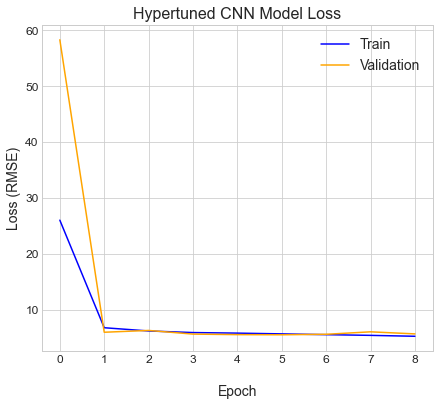

In [161]:
# Plot the training loss curve of our finalised CNN model
plot_history(cnn_history, 'Hypertuned CNN')

The best hypertuned `CNN` model produces an `RMSE` of $\approx 5.4958$ on epoch 6/50 (due to early stopping). Now that we have the optimal number of epochs (6) for our `CNN`, we use it in a new fitting procedure to obtain the best hypertuned `CNN` model performance. Then, we can take the fitted model and save it as our finalised `CNN` which we can test for generalisability on unseen data instances.

In [34]:
# Create a TensorBoard callback for visualising the results after hypertuning
tb_callback = tf.keras.callbacks.\
    TensorBoard(f'cnn_final_results/cnn_logs', profile_batch=0)

# Rebuild our final CNN model
cnn_hypermodel = cnn_tuner.hypermodel.build(best_cnn_hps)

# Retrain the model using the best training loss epoch obtained
# previously and finalise the CNN (use an early stopping just in case)
cnn_hyper_history = cnn_hypermodel.fit(X_train_32, y_train,
                                       validation_split=0.25,
                                       epochs=best_cnn_epoch, 
                                       callbacks=[tb_callback, es_callback])

Random number generator seed reset!
Epoch 1/6
431/431 [==============================] - 4s 9ms/step - loss: 892.0939 - root_mean_squared_error: 26.0204 - mean_absolute_error: 21.0216 - val_loss: 3403.5278 - val_root_mean_squared_error: 58.3398 - val_mean_absolute_error: 56.3570
Epoch 2/6
431/431 [==============================] - 4s 8ms/step - loss: 45.6615 - root_mean_squared_error: 6.7573 - mean_absolute_error: 5.2469 - val_loss: 35.3893 - val_root_mean_squared_error: 5.9489 - val_mean_absolute_error: 4.5132
Epoch 3/6
431/431 [==============================] - 4s 8ms/step - loss: 38.1585 - root_mean_squared_error: 6.1773 - mean_absolute_error: 4.7671 - val_loss: 39.3373 - val_root_mean_squared_error: 6.2719 - val_mean_absolute_error: 4.4594
Epoch 4/6
431/431 [==============================] - 4s 8ms/step - loss: 34.7131 - root_mean_squared_error: 5.8918 - mean_absolute_error: 4.5540 - val_loss: 31.5537 - val_root_mean_squared_error: 5.6173 - val_mean_absolute_error: 4.2315
Epoch 5/6

Our final `CNN` model outputs (again) an `RMSE` of $\approx 5.4958$. This is an improvement (drop) of $\approx 2.56\%$ (from 5.6403) in contrast to the default `CNN` model training loss performance. As for the default `MLP` model, this percentage jumps to $\approx 5.77\%$ (from 5.8323).

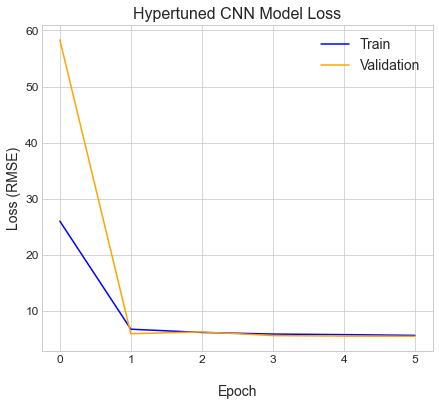

In [162]:
# Plot the training loss curve of our finalised CNN model
plot_history(cnn_hyper_history, 'Hypertuned CNN')

We see that the `CNN` hypermodel performance is improving over time, meaning that it is learning. Also, it reaches a plateau considerably early which is a sign that the hypertuned model could benefit from a lower learning rate. Currently, the `CNN` hypermodel employs a learning rate of 0.001 which is the default of the `Adam` optimiser. We leave such retuning procedure as a future work due to time constraints.

In [177]:
cnn_eval_result = cnn_hypermodel.evaluate(X_test_32, y_test)
cnn_final_df = pd.DataFrame(cnn_eval_result, index=['MSE', 'RMSE', 'MAE'], columns=['CNN Test Loss'])
cnn_final_df

144/144 [==============================] - 1s 6ms/step - loss: 28.7404 - root_mean_squared_error: 5.3610 - mean_absolute_error: 4.0238


,CNN Test Loss
MSE,28.740444
RMSE,5.361012
MAE,4.023798


The `CNN` hypermodel holdout test set evaluation presents an `RMSE` decrease of $\approx 3.2\%$. We can consider this as a fair improvement to the baseline `CNN` we evaluated earlier standing at $\approx 5.5384$ `RMSE`.

##### MLP Hypertuning

In [37]:
# Run the hypertuning procedure for the MLP model
mlp_tuner, best_mlp_model, best_mlp_hps = run_hypertune(mlp_builder, 'mlp')

INFO:tensorflow:Reloading Oracle from existing project mlp_tuner_results\mlp\oracle.json
Random number generator seed reset!
INFO:tensorflow:Reloading Tuner from mlp_tuner_results\mlp\tuner0.json
INFO:tensorflow:Oracle triggered exit
Random number generator seed reset!


In [303]:
# Get the top 3 best performing model summary results
print('The MLP hypertuning is complete.' +
      ' Printing best model hyperparameter' +
      ' configuration results...\n')
mlp_tuner.results_summary(3)

# Print the model architecture summary
print('\nShowing the best MLP model architecture summary...\n')
best_mlp_model.summary()

The MLP hypertuning is complete. Printing best model hyperparameter configuration results...

Results summary
Results in mlp_tuner_results\mlp
Showing 3 best trials
Objective(name='val_root_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
dense_units_1: 128
dense_units_2: 96
learning_rate: 0.001
batch_size: 32
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 5.8923749923706055
Trial summary
Hyperparameters:
dense_units_1: 96
dense_units_2: 64
learning_rate: 0.001
batch_size: 32
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 5.925454139709473
Trial summary
Hyperparameters:
dense_units_1: 128
dense_units_2: 64
learning_rate: 0.01
batch_size: 32
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: d9f08085e07f5af5b27276f045deb49d
Score: 5.9325408935546875

Showing the best MLP model architecture summary...

Model: "sequential"
______________________________________________

As a result, we obtain a validation `RMSE` of $\approx 5.8924\%$.

We follow the same steps as for the `CNN` model previously:

 1. Build a new `MLP` model with the acquired best hyperparameter settings.
 
 
 2. Train the model for 50 epochs to cause overfitting and thus detect the optimal epoch number
 
 
 3. Save the optimal epoch number to be used to obtain our final `MLP` model.
 
The early stopping is set to `patience=3` again.

In [40]:
# Build the model with the optimal hyperparameters 
# and train it on the data for 50 epochs
mlp_tuned = mlp_tuner.hypermodel.build(best_mlp_hps)
mlp_tuned_history = mlp_tuned.fit(X_train_32, y_train, epochs=50, 
                                  validation_split=validation_split,
                                  callbacks=[es_callback])

# Get the RMSE of every epoch and detect the number of the epoch
# that has led to the best result
mlp_rmse_epoch = mlp_tuned_history.history['val_root_mean_squared_error']
best_mlp_epoch = mlp_rmse_epoch.index(min(mlp_rmse_epoch)) + 1
print('\nMLP best epoch: %d' % (best_mlp_epoch,))

Random number generator seed reset!
Epoch 1/50
431/431 [==============================] - 2s 5ms/step - loss: 127.1021 - root_mean_squared_error: 10.1322 - mean_absolute_error: 7.3655 - val_loss: 58.1037 - val_root_mean_squared_error: 7.6226 - val_mean_absolute_error: 5.4850
Epoch 2/50
431/431 [==============================] - 2s 5ms/step - loss: 70.8513 - root_mean_squared_error: 8.4173 - mean_absolute_error: 6.4248 - val_loss: 49.9655 - val_root_mean_squared_error: 7.0686 - val_mean_absolute_error: 5.0033
Epoch 3/50
431/431 [==============================] - 2s 5ms/step - loss: 62.9393 - root_mean_squared_error: 7.9334 - mean_absolute_error: 6.0641 - val_loss: 46.3918 - val_root_mean_squared_error: 6.8112 - val_mean_absolute_error: 4.8580
Epoch 4/50
431/431 [==============================] - 2s 5ms/step - loss: 59.5503 - root_mean_squared_error: 7.7169 - mean_absolute_error: 5.9529 - val_loss: 47.5282 - val_root_mean_squared_error: 6.8941 - val_mean_absolute_error: 5.0666
Epoch 5/50

Next, we proceed to finalising our `MLP` model using the best epoch number of 16.

In [43]:
# Create a TensorBoard callback for visualising the results after hypertuning
tb_callback = tf.keras.callbacks.TensorBoard(f'mlp_final_results/mlp_logs', \
                                             profile_batch=0)

# Rebuild the MLP model for one last time
mlp_hypermodel_final = mlp_tuner.hypermodel.build(best_mlp_hps)

# Retrain the model
mlp_final_history = mlp_hypermodel_final.fit(X_train_32, y_train, epochs=best_mlp_epoch,
                                             validation_split=validation_split,
                                             callbacks=[es_callback, tb_callback])

Random number generator seed reset!
Epoch 1/16
431/431 [==============================] - 3s 5ms/step - loss: 127.1021 - root_mean_squared_error: 10.2047 - mean_absolute_error: 7.2344 - val_loss: 58.1037 - val_root_mean_squared_error: 7.6226 - val_mean_absolute_error: 5.4850
Epoch 2/16
431/431 [==============================] - 2s 5ms/step - loss: 70.8513 - root_mean_squared_error: 8.4173 - mean_absolute_error: 6.4248 - val_loss: 49.9655 - val_root_mean_squared_error: 7.0686 - val_mean_absolute_error: 5.0033
Epoch 3/16
431/431 [==============================] - 2s 5ms/step - loss: 62.9393 - root_mean_squared_error: 7.9334 - mean_absolute_error: 6.0641 - val_loss: 46.3918 - val_root_mean_squared_error: 6.8112 - val_mean_absolute_error: 4.8580
Epoch 4/16
431/431 [==============================] - 2s 5ms/step - loss: 59.5503 - root_mean_squared_error: 7.7169 - mean_absolute_error: 5.9529 - val_loss: 47.5282 - val_root_mean_squared_error: 6.8941 - val_mean_absolute_error: 5.0666
Epoch 5/16

The obtained `RMSE` is at $\approx 5.8924$. This is a sign that we might have missed the right values for our hyperparameter space regarding the `MLP`.

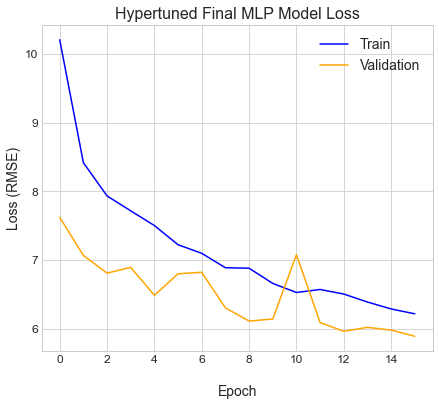

In [163]:
# Plot the MLP training and validation RMSE loss curves
plot_history(mlp_final_history, 'Hypertuned Final MLP')

The loss curves of the hypertuned `MLP` hypermodel indicate a progressive learning of the model. However, compared to the `CNN`, it seems that the `MLP` hypermodel would benefit from a slightly higher learning rate. Also, it does not reaches a plateau but the validation curve fluctates at times which might have caused the early stopping. Therefore, improvements to consider in the future are exploring a wider range of hyperparameter values.

In [176]:
# Evaluate the model on the holdout test set and store the result 
# in a Pandas data frame which we use for plotting later
mlp_final_eval = mlp_hypermodel_final.evaluate(X_test_32, y_test)
mlp_final_df = pd.DataFrame(mlp_final_eval, index=['MSE', 'RMSE', 'MAE'], columns=['MLP Test Loss'])
mlp_final_df

144/144 [==============================] - 1s 6ms/step - loss: 33.3451 - root_mean_squared_error: 5.7745 - mean_absolute_error: 4.3058


,MLP Test Loss
MSE,33.345062
RMSE,5.774518
MAE,4.305819


Here, we actually observe an increase of $\approx 0.2\%$ in `RMSE` regarding the baseline `MLP` model. This outcome is, indeed, quite surprising but it also indicates that we might have experimented with the wrong hyperparameter search space for the `MLP`. However, as mentioned previously, we leave retuning as a future research task.

## Subtask d. Cross-Validation

- To begin with, Cross-Validation (CV) is employed as a first-order measure of model stability. It is not intended for predicting performance in real-world scenarios (unseen data). The only way to achieve this is to test the finalised model on a real-world setting exploiting its generalisation ability.


- CV provides a risk analysis about architectures. Given that a model appears to be stable, one may decide to run the model through a real-world test.


- As a tuning approach, CV produces only one output &mdash; a model (or component of a model such as the best hyperparameter). It does not offer a model evaluation since it must be performed on an independent test set, which is why we set a holdout data aside exactly for that. 


- The final model is created using the whole training set rather than taking any of the individual CV fold models. CV assesses the performance stability of the model or in other words its generalisability. 


- Without CV we would be picking based solely on the maximum performance without concern to its robustness. 


We define a simple `KFold` CV function as follows:

In [81]:
from sklearn.model_selection import KFold

def model_cv(model_type, images, labels, errors_dict, folds=5):
    """
    Cross-validate a model
    Adapted from: https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
    """
    # Get the appropriate tuner and hyperparameters
    # specified the model_type argument. We pick
    # between CNN and MLP tuners and hyperparameters
    if model_type == 'cnn':
        tuner = cnn_tuner
        hps = best_cnn_hps
    else:
        tuner = mlp_tuner
        hps = best_mlp_hps
        
    # Define the k-fold CV (default folds = 5)
    cv = KFold(n_splits=folds, shuffle=True, random_state=1337)

    # Start the CV loop
    fold_no = 1  # Initialise the fold number
    for train, test in cv.split(images, labels):
        
        # For better visualisation of the procedure
        print('-'*40)
        print(f'Fold {fold_no}')
        print('-'*40)
        
        # Get the model architecture
        model = tuner.hypermodel.build(hps)
        
        # Compile the model
        model.compile(loss=loss_function,\
                      optimizer=optimiser,\
                      metrics=metrics)

        # Fit data to model
        history = model.fit(images[train], labels[train],\
                            batch_size=batch_size,\
                            epochs=5,\
                            verbose=verbosity)

        # Generate generalisation metrics
        scores = model.evaluate(images[test], labels[test], verbose=0)
        errors_dict['MSE'].append(scores[0])
        errors_dict['RMSE'].append(scores[1])
        errors_dict['MAE'].append(scores[2])
        
        # Increment the fold number
        fold_no += 1

### Cross-Validating the CNN Model

In [82]:
# Create a dictionary to hold the evaluation
# scores (on the validation set) after each fold
cnn_error_scores = {
    'MSE': [],
    'RMSE': [],
    'MAE': []
}

# Use a 5-fold cross-validation
folds = 5

# Run the cross-validation
model_cv('cnn', X_train_32, y_train, cnn_error_scores, folds)

----------------------------------------
Fold 1
----------------------------------------
Random number generator seed reset!
Epoch 1/5
460/460 [==============================] - 6s 11ms/step - loss: 839.9001 - root_mean_squared_error: 29.4580 - mean_absolute_error: 25.6892
Epoch 2/5
460/460 [==============================] - 5s 10ms/step - loss: 43.9720 - root_mean_squared_error: 6.6311 - mean_absolute_error: 5.1514
Epoch 3/5
460/460 [==============================] - 4s 8ms/step - loss: 37.0192 - root_mean_squared_error: 6.0843 - mean_absolute_error: 4.6789
Epoch 4/5
460/460 [==============================] - 4s 8ms/step - loss: 34.7202 - root_mean_squared_error: 5.8924 - mean_absolute_error: 4.5520
Epoch 5/5
460/460 [==============================] - 4s 8ms/step - loss: 33.3514 - root_mean_squared_error: 5.7751 - mean_absolute_error: 4.4505
----------------------------------------
Fold 2
----------------------------------------
Random number generator seed reset!
Epoch 1/5
460/460 [=

In [83]:
# Create a Pandas data frame to hold the evaluation score results of each CV fold
cnn_cv_df = pd.DataFrame(cnn_error_scores, index=[f'Fold {i+1}' for i in range(folds)])
cnn_cv_df

,MSE,RMSE,MAE
Fold 1,29.909220,5.468932,4.064506
Fold 2,33.171619,5.759481,4.393054
Fold 3,47.001015,6.855729,5.407125
Fold 4,42.207355,6.496719,4.887466
Fold 5,29.287195,5.411765,4.062128


In [84]:
# Describe the previously created evaluation data frame
# showing the mean, max, std etc. values of each column
cnn_cv_df.describe()

,MSE,RMSE,MAE
count,5.000000,5.000000,5.000000
mean,36.315281,5.998525,4.562856
std,7.893283,0.645154,0.580103
min,29.287195,5.411765,4.062128
25%,29.909220,5.468932,4.064506
50%,33.171619,5.759481,4.393054
75%,42.207355,6.496719,4.887466
max,47.001015,6.855729,5.407125


The hypertuned `CNN` evaluation data frame description displays the following critical info:

- Mean `MSE` $= 36.3152$


- Mean `RMSE` $= 5.9985$


- Mean `MAE` $= 4.5629$

Now, let us observe what the `MLP` hypertuned model outputs will be for the 5-fold CV procedure.

### Cross-Validating the MLP Model

In [85]:
# Create a dictionary to hold the evaluation
# scores (on the validation set) after each fold
mlp_error_scores = {
    'MSE': [],
    'RMSE': [],
    'MAE': []
}

# Cross-validate the best MLP hypermodel
model_cv('mlp', X_train_32, y_train, mlp_error_scores, folds)

----------------------------------------
Fold 1
----------------------------------------
Random number generator seed reset!
Epoch 1/5
460/460 [==============================] - 2s 4ms/step - loss: 124.9778 - root_mean_squared_error: 10.2879 - mean_absolute_error: 7.2829
Epoch 2/5
460/460 [==============================] - 2s 4ms/step - loss: 69.0478 - root_mean_squared_error: 8.3095 - mean_absolute_error: 6.3057
Epoch 3/5
460/460 [==============================] - 2s 4ms/step - loss: 63.3344 - root_mean_squared_error: 7.9583 - mean_absolute_error: 6.0740
Epoch 4/5
460/460 [==============================] - 2s 4ms/step - loss: 58.7827 - root_mean_squared_error: 7.6670 - mean_absolute_error: 5.8755
Epoch 5/5
460/460 [==============================] - 2s 4ms/step - loss: 55.6269 - root_mean_squared_error: 7.4583 - mean_absolute_error: 5.7462
----------------------------------------
Fold 2
----------------------------------------
Random number generator seed reset!
Epoch 1/5
460/460 [====

In [87]:
# Store the MLP CV evaluation scores in a Pandas data frame
# which we will use for some beautiful plots later on
mlp_cv_df = pd.DataFrame(mlp_error_scores, index=[f'Fold {i+1}' for i in range(folds)])
mlp_cv_df

,MSE,RMSE,MAE
Fold 1,37.639095,6.135071,4.531947
Fold 2,42.441380,6.514705,4.847640
Fold 3,42.130489,6.490800,4.769778
Fold 4,43.630100,6.605309,4.949745
Fold 5,40.507881,6.364580,4.866424


In [88]:
# Describe the MLP CV evaluation data frame
# showing the mean, max, std etc. values of each column
mlp_cv_df.describe()

,MSE,RMSE,MAE
count,5.000000,5.000000,5.000000
mean,41.269789,6.422093,4.793107
std,2.315542,0.182041,0.159400
min,37.639095,6.135071,4.531947
25%,40.507881,6.364580,4.769778
50%,42.130489,6.490800,4.847640
75%,42.441380,6.514705,4.866424
max,43.630100,6.605309,4.949745


The `MLP` hypermodel evaluation data frame description displays the following critical info:

- Mean `MSE` $= 41.2698$


- Mean `RMSE` $= 6.4221$


- Mean `MAE` $= 4.7931$

### Analysing the `MLP` and `CNN` Cross-Validation Results

In this part (for the sake of simplicity and to save words) we will mention and compare only the `RMSE` metric evaluation performances of both models.

Obviously, the `MLP` model is significantly outperformed by the optimised `CNN` model. Specifically, the more sophisticated `CNN` architecture displays an improvement (decrease) of $\approx 6.60\%$ as opposed to the `MLP` mean validation `RMSE`. This confirms the statement that when dealing with images the `CNN` achieves a better performance. This is because it can understand the image pixel relations and is often the preffered choice for image or video classification tasks.

On the other hand, the `MLP` is generally employed in simple image classification tasks. Its simple architecture allows for fast model training which realise good overall output performance.

Finally, the obtained CV results (displayed above) depict that the `CNN` hypermodel is definitely more stable and will make better predictions on completely unseen data. Nevertheless, there is still room for improvement as will be detailed in-depth in the following last section.

#### MLP vs CNN Mean CV Loss

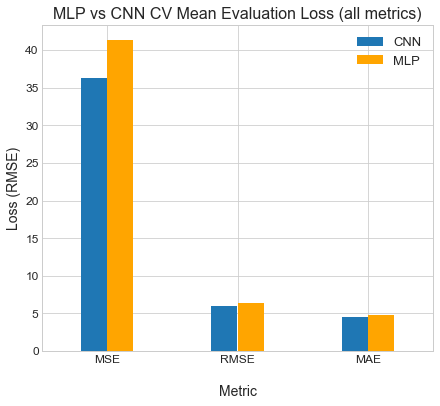

In [296]:
# Initialise a matplot figure
fig = plt.figure(figsize=(7,6))

# Create matplotlib axes, define the figure and plot
# (code is rather straightforward)
ax_bar = fig.add_subplot(111)
plt.title('MLP vs CNN CV Mean Evaluation Loss (all metrics)', fontsize=16)

# Plot the mean metric values on the axes
cnn_cv_df.mean(axis=0).plot(kind='bar', ax=ax_bar, width=.2, position=1)
mlp_cv_df.mean(axis=0).plot(kind='bar', ax=ax_bar, color='orange', width=.2, position=0)
plt.legend(['CNN', 'MLP'], prop={'size': 13})
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.xlim(-0.5,2.5)
plt.xlabel('\nMetric', fontsize=14)
plt.ylabel('Loss (RMSE)', fontsize=14)
plt.show()

We can clearly see the difference between the `CNN` and `MLP` mean CV results where the former are superior.

## Subtask d. Inference

Since we already evaluated both hypertuned models in Subtask b., here, we present some graphs to visualise the achieved results. We visualise the various metric value of the predictions obtained by the models.

**Note**: Your results may vary given the stochastic nature of the algorithm, evaluation procedure, or differences in numerical precision. 


### Discussing the Results and Proposing Future Work

#### The CNN Hypermodel

As we saw previously, the `CNN` hypertuning resulted in a decent generalisation performance increase ($\approx 3.2\%$) as to the baseline model. Let us now look at the hyperparameters of our baseline and best hypermodel:

- `Conv2D` layer 1 &ndash; 64 (hypermodel) vs 32 (baseline)


- `Conv2D` layer 2 &ndash; 128 (hypermodel) vs 64 (baseline)


- `Dense` layer &ndash; 128 (hypermodel) vs 256 (baseline)


- Batch size &ndash; both the hypermodel and the baseline architecture adopt a batch size of 32 (default).

- Learning rate &ndash; both adopt a learning rate of 0.001 or the default for the `Adam` optimiser.

Therefore, we infer that the more filters we have in the `Conv2D` layers, the better the model generalises on unseen data. Also, in this case it is better to have a simpler (less units) `Dense` layer.



Future work
adding and removing layers should be tried

#### The MLP Hypermodel

The hypertuned `MLP` architecture failed to surpass the evaluation `RMSE` of the baseline model. Both models performed identically with a negligible difference in `RMSE` of only 0.011.

- `Dense` layer 1 &ndash; 128 (hypermodel) vs 64 (baseline)


- `Dense` layer 2 &ndash; 96 (hypermodel) vs 32 (baseline)


- Batch size &ndash; both the hypermodel and the baseline architecture adopt a batch size of 32 (default).


- Learning rate &ndash; both adopt a learning rate of 0.001 or the default for the `Adam` optimiser.

This implies that either the model is suboptimal for such a real-world dataset or we have not observed a sufficient number of candidate models.

#### Conclusion and Future Work

At the end of the day, there is no such model that fits all tasks. Therefore, every optimisation done should be adapted to the specific case and its data. Here, we are not trying to develop a model that outperforms the state-of-the art ones (due to time constraints at least) but to demonstrate our understanding of how a model should be developed and evaluated. Some points to consider in the future which might improve the results achieved in this research:

- Introduction of new layers to the model architectures we tested &ndash; this could be achieved via hypertuning or manually and could lead to better generalisation performance on this or similar problem domains.


- Trying different optimisers with learning rate decay &ndash; we employed one of the most widely adopted optimiser in machine learning. However, we did not experiment with any other which might provide better results.


- Adjusting early stopping &ndash; we set `patience=3` which might be too harsh of a value for early stopping the training process.


- Using a wider range of values when tuning &ndash; we should apply that to the current and future hyperparameters.


- Experimenting with the hypertuning procedure &ndash; we could adopt a method which combines the Keras Tuner class with a k-fold cross-validation, or use a nested cross-validation loop instead.  


- Running on CPU? &ndash; painfully slow and we do not know if it would make any difference at all...


### Final Plots

#### Per Fold `MLP` vs `CNN` Cross-Validation Loss Results

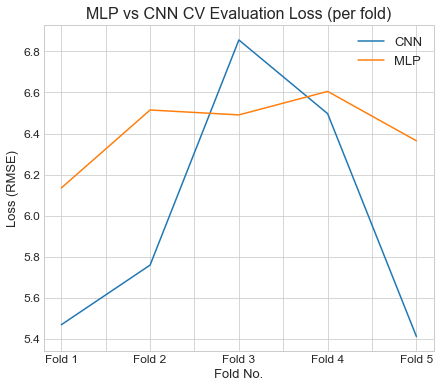

In [284]:
# Plot the MLP vs CNN CV per fold evaluation loss line graph
plt.figure(figsize=(7,6))
ax = cnn_cv_df['RMSE'].plot()
mlp_cv_df['RMSE'].plot(ax=ax)
plt.title('MLP vs CNN CV Evaluation Loss (per fold)', fontsize=16)
plt.xlabel('Fold No.', fontsize=13)
plt.ylabel('Loss (RMSE)', fontsize=13)
plt.legend(['CNN', 'MLP'], prop={'size': 13})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The `MLP` seems more stable over the folds, but the `CNN` demonstrates lower `RMSE` on average.

#### Baseline vs Final `RMSE` Model Results

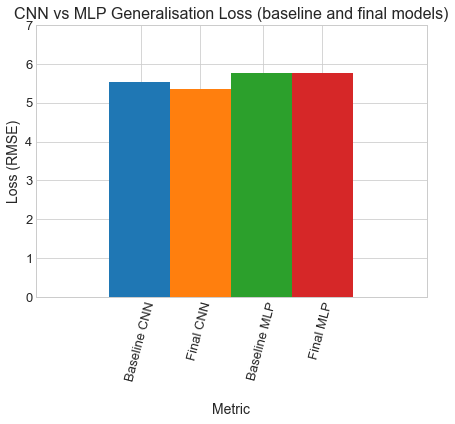

In [301]:
# Store the results of the baseline and final models in a data frame
final_data = [cnn_base_df.iloc[1][0], cnn_final_df.iloc[1][0], mlp_base_df.iloc[1][0], mlp_final_df.iloc[1][0]]
cnn_vs_mlp_df = pd.DataFrame(final_data, index=['Baseline CNN','Final CNN','Baseline MLP','Final MLP'])

# Visualise the overall RMSE evaluation results of the baseline and final models
cnn_vs_mlp_df.T.plot(kind='bar', legend=False, figsize=(7,5), ylim=(0,7), width=.5)
plt.title('CNN vs MLP Generalisation Loss (baseline and final models)', fontsize=16)
plt.xlim(-0.4,0.4)
plt.xticks([-0.185,-0.065,0.065,0.185], 
           labels=cnn_vs_mlp_df.index,
           fontsize=13,
          rotation=75)
plt.yticks(fontsize=13)
plt.xlabel('\nMetric', fontsize=14)
plt.ylabel('Loss (RMSE)', fontsize=14)
plt.show()

The hypertuned `CNN` model generalises best on the unseen holdout test set as seen above.